# utilisation d'un catalogue .zarr Icechunkpour ouvrir l'archive Gamar

In [1]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return

In [2]:
import os
os.environ['SHELL'] = '/bin/bash'

In [3]:
# open_virtual_dataset version using ds.virtualize.to_icechunk(session.store)   # ca cree l'archive dans le storage indiquee plus haut
ICECHUNK_CATALOG='/scale/project/lops-oh-fair2adapt/fpaul/tmp/riomarr.zarr'

# or, http urls inside (!timeout si depuis ifremer...):


Note : pattern usuel requis : 

toujours : Repository.open(...) -> session -> session.store -> xr.open_zarr(store).

## Catalogue icechunk local, ouverture avec open_dataset pour usage_courant

In [4]:
import icechunk

In [5]:
config = icechunk.RepositoryConfig.default()
config.set_virtual_chunk_container(
    icechunk.VirtualChunkContainer("file:///scale/project/lops-oh-fair2adapt/riomar/GAMAR/", 
    icechunk.local_filesystem_store("/scale/project/lops-oh-fair2adapt/riomar"))
)


In [6]:
outpath = '/scale/project/lops-oh-fair2adapt/fpaul/tmp/'

storage = icechunk.local_filesystem_storage(os.path.join(outpath,"riomar.zarr"))
storage

  2025-12-11T13:55:40.946395Z  WARN icechunk::storage::object_store: The LocalFileSystem storage is not safe for concurrent commits. If more than one thread/process will attempt to commit at the same time, prefer using object stores.
    at icechunk/src/storage/object_store.rs:80



ObjectStorage(backend=LocalFileSystemObjectStoreBackend(path=/scale/project/lops-oh-fair2adapt/fpaul/tmp/riomar.zarr))

In [7]:
credentials = credentials = icechunk.containers_credentials(
    { "file:///scale/project/lops-oh-fair2adapt/riomar/GAMAR/": None,}
)

repo = icechunk.Repository.open(
    storage, 
    config,
    authorize_virtual_chunk_access=credentials
)   ## cree le dossier dans storage, qui ne doit pas exister. Ici : /scale/project/lops-oh-fair2adapt/fpaul/tmp/riomar.zarr


In [8]:
rs = repo.readonly_session(branch="main")
rs

In [14]:
import xarray as xr

## Ouverture = instantané
vds_combined = xr.open_dataset(rs.store, engine="zarr", chunks={}, 
                           decode_times=True, 
                           consolidated=False)

print("✅ Combined shape:", vds_combined.temp.shape)
display(vds_combined.chunk)

✅ Combined shape: (201600, 40, 838, 727)


<bound method Dataset.chunk of <xarray.Dataset> Size: 79TB
Dimensions:              (time_counter: 201600, s_w: 41, s_rho: 40, y_rho: 838,
                          x_rho: 727, y_u: 838, x_u: 726, y_v: 837, x_v: 727,
                          axis_nbounds: 2)
Coordinates: (12/19)
  * time_counter         (time_counter) datetime64[ns] 2MB 2020-02-01T00:52:3...
  * s_w                  (s_w) float32 164B -1.0 -0.975 -0.95 ... -0.025 0.0
  * s_rho                (s_rho) float32 160B -0.9875 -0.9625 ... -0.0125
  * y_rho                (y_rho) float32 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho                (x_rho) float32 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * y_u                  (y_u) float32 3kB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                   ...
    nav_lon_rho          (y_rho, x_rho) float32 2MB dask.array<chunksize=(838, 727), meta=np.ndarray>
    nav_lon_u            (y_u, x_u) float32 2MB dask.array<chunksize=(838, 726), meta=np.ndarray>
    nav_lon_v   

In [15]:
temp = vds_combined.temp.isel(time_counter=700, s_rho=0)
print("Mean:", temp.mean().compute().item())  # Force compute
temp


Mean: 7.816941738128662


<xarray.DataArray 'temp' (y_rho: 838, x_rho: 727)> Size: 2MB
dask.array<getitem, shape=(838, 727), dtype=float32, chunksize=(838, 727), chunktype=numpy.ndarray>
Coordinates:
  * y_rho         (y_rho) float32 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  * x_rho         (x_rho) float32 3kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    nav_lat_rho   (y_rho, x_rho) float32 2MB dask.array<chunksize=(838, 727), meta=np.ndarray>
    nav_lon_rho   (y_rho, x_rho) float32 2MB dask.array<chunksize=(838, 727), meta=np.ndarray>
    s_rho         float32 4B -0.9875
    time_counter  datetime64[ns] 8B 2014-03-01T04:54:45
    time_instant  datetime64[ns] 8B dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    long_name:           potential temperature
    units:               Celsius
    online_operation:    instant
    interval_operation:  1 h
    interval_write:      1 h
    cell_methods:        time: point

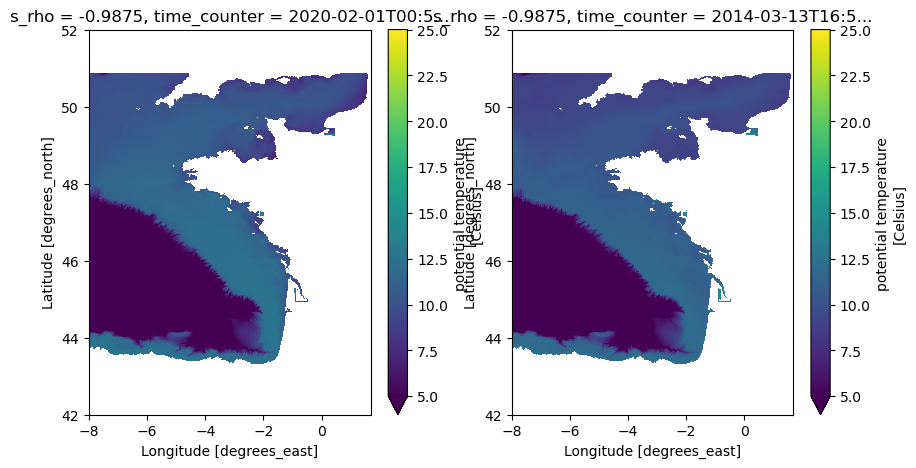

In [21]:
from matplotlib import pyplot as plt
plt.subplots(1,2, figsize=(10,5))

plot_kwargs = {
    'x': 'nav_lon_rho',
    'y': 'nav_lat_rho',
    #'cmap': 'RdBu_r',
    'ylim': (42, 52),
    'vmin': 5,
    'vmax': 25
}
plt.subplot(1,2,1)
vds_combined.isel(time_counter=0).temp.isel(s_rho=0).plot( **plot_kwargs )  
plt.subplot(1,2,2)
vds_combined.isel(time_counter=1000).temp.isel(s_rho=0).plot( **plot_kwargs )  

## Catalogue Icechunk local, ouverture avec open_zarr
(pour analyse des manifests, réécriture des paths, divers..)

FP : bof, en fait je fais pas, y'a aucun interet dans mon cas

## Différences pratiques
| Critère | `open_dataset(..., engine="zarr")` | `open_zarr(...)` |
|---------|-----------------------------------|------------------|
| **Flexibilité** | ✅ Plus d'options (decode_cf, mask_and_scale...) | ❌ Zarr-only |
| **Décodage CF** | ✅ Temps, unités, scaling automatique | ❌ Métadonnées Zarr brutes |
| **Chunks** | ✅ `chunks={}` force lazy loading | ✅ `chunks="auto"` recommandé |
| **Store objet** | ✅ `rs.store` directement | ✅ `rs.store` directement |

## Catalogue Icechunk http

TODO : A FAIRE !!!


attention, ca c'est probablemnet d'actualité encore... : 
- Note Fred : ca marche a l'exterieur d'ifremer, mais pas depuis le hpc ifremer par exemple (timeout!)...
- Avec Colab, (mettre url si ok) : 

In [22]:
# NOTE FP : a ce jour, il ne semble pas possible d'utiliser par http le catalogue icechunk virtualizarr,
# contrairement à kerchunk ... En local ok, mais pas en remote http, sauf à utiliser du s3 ou des trucs du style